### Importing Required Libraries:::

In [75]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [105]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
import string
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
from wordcloud import WordCloud

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [77]:
reviewDataset = pd.read_csv("/content/drive/MyDrive/data/IMDB_dataset.csv")
pveReviews = reviewDataset[reviewDataset['sentiment'] == 'positive']
nveReviews = reviewDataset[reviewDataset['sentiment'] == 'negative']

pveReviews = pveReviews.iloc[:3000]
nveReviews = nveReviews.iloc[:3000]

tmpReviewDataset = pd.concat([pveReviews, nveReviews])

reviewDataset = tmpReviewDataset.sample(frac=1).reset_index(drop=True)
reviewDataset.head()

,review,sentiment
0,It takes a very special kind of person to make...,positive
1,I haven't seen the first two - only this one w...,negative
2,There are exactly 2 good things to be said abo...,negative
3,This is the least scary film i have ever seen....,negative
4,The Brave One is about a New York radio show h...,negative


- We have large dataset by which there's issue while trainning. so, I reduced the dataset to 6000 with equal number of negative and positive reviews.

In [78]:
reviewDataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     6000 non-null   object
 1   sentiment  6000 non-null   object
dtypes: object(2)
memory usage: 93.9+ KB


- From this information, we can see there is no null values for the feature, the total data is 6000 and both are of object types.

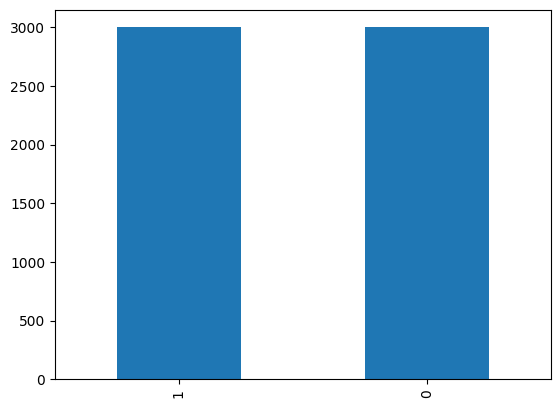

In [112]:
sentiment_counts = reviewDataset['sentiment'].value_counts()
sentiment_counts.plot(kind='bar')
plt.show()

- We can also verify from this plot that we have taken equal samples from reviews for positive and negative reviews.

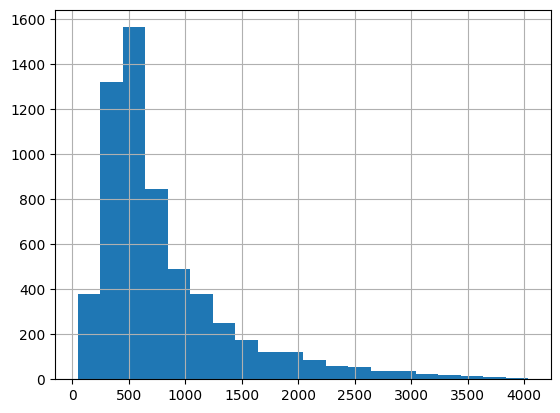

In [104]:
review_lengths = reviewDataset['review'].apply(len)
review_lengths.hist(bins=20)
plt.show()

- We can see average length of the reviews comes at 500, there are some length of reviews upto 4000 also. Depending on which kind of review have such high length can make the prediction biased towards it if in case the concentraion was higher for only one type.

In [80]:
label_encoder = LabelEncoder()
reviewDataset["sentiment"] = label_encoder.fit_transform(reviewDataset["sentiment"])

In [81]:
reviewDataset.head()

,review,sentiment
0,It takes a very special kind of person to make...,1
1,I haven't seen the first two - only this one w...,0
2,There are exactly 2 good things to be said abo...,0
3,This is the least scary film i have ever seen....,0
4,The Brave One is about a New York radio show h...,0


### Preprocess Text Data(Remove punctuation, Perform Tokenization, Remove stopwords and Lemmatize/Stem):

In [82]:
# This function will remove the puntuation as well as stop words and our custom stop words
def cleanTheText(words):
    stop_words = set(stopwords.words('english'))
    custom_stop_words = ["-",'""',"``","'"]
    return [word for word in words if word.lower() not in stop_words and word.lower() not in custom_stop_words and word.lower() not in string.punctuation]

# This function will tokenize our text
def wordTokenizer(text):
    tokens = word_tokenize(text)
    return tokens

# This function will stem our text
def stemming(text):
    return " ".join([stemmer.stem(word) for word in text.split()])

# This will lemmatize our text
def lemmatization(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

In [83]:
reviewDataset['review'] = reviewDataset['review'].str.lower()

In [84]:
reviewDataset['review'] = reviewDataset['review'].apply(stemming)

In [85]:
reviewDataset['review'] = reviewDataset['review'].apply(lemmatization)

In [86]:
reviewDataset["review"] = reviewDataset['review'].apply(wordTokenizer)

In [87]:
reviewDataset["review"] = reviewDataset["review"].apply(cleanTheText)

In [88]:
# so joining all tokens so that we can do vectorization for the remaining text
reviewDataset['review'] = reviewDataset['review'].apply(lambda tokens: ' '.join(tokens))

In [89]:
reviewDataset.head()

,review,sentiment
0,take veri special kind person make movi wretch...,1
1,n't seen first two onli thi one call primal sp...,0
2,exactli 2 good thing said fantasies '' mention...,0
3,thi least scari film ever seen blob manag eat ...,0
4,brave one new york radio show host name erica ...,0


In [90]:
X_train, X_temp, Y_train, Y_temp = train_test_split(reviewDataset['review'], reviewDataset['sentiment'], test_size=0.4, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

- So, I have divided the dataset to 60-20-20 ratio for trainning, validation and test of the models

### Perform TFIDF Vectorization:

In [91]:
tfidf_vectorizer = TfidfVectorizer()

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

X_val_tfidf = tfidf_vectorizer.transform(X_val)

X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [92]:
df_vect = pd.DataFrame(X_train_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
df_vect.head()

,00,000,007,01,0126,02,041,05,050,06,...,zzzz,zzzzzzzzzzzzzzzzzz,álex,élan,émigré,émigrés,ís,ïn,óli,über
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


- I have just printed the trainning data converted to vectors, just to see how it looks.

### Exploring parameter settings using GridSearchCV on Random Forest & Gradient Boosting/Xgboost classifier:

In [93]:
# Grid search function for finding best scores and params.
def findBestScoreAndParams(model, params, X_train, Y_train):
    grid_search_cv = GridSearchCV(model, params, cv=5, n_jobs=-1, scoring="accuracy")
    grid_search_cv.fit(X_train, Y_train)
    print(f"Best Hyperparameters for model train dataset::")
    print(grid_search_cv.best_params_)
    print(f"Best Score for model train dataset::", round(grid_search_cv.best_score_,3),'\n')

In [94]:
params_for_rf = {
    'n_estimators': [10, 20, 50],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 3, 5],
    'min_samples_leaf': [1, 2, 4]
}

RfModel = RandomForestClassifier(n_jobs=-1)

findBestScoreAndParams(RfModel, params_for_rf, X_train_tfidf, Y_train)

Best Hyperparameters for model train dataset::
{'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 50}
Best Score for model train dataset:: 0.819 



In [95]:
params_for_gb = {
"n_estimators": [10, 20, 30],
"learning_rate": [0.5, 1, 1.5],
"max_depth": [2, 3]
}

GbModel = GradientBoostingClassifier()

findBestScoreAndParams(GbModel, params_for_gb, X_train_tfidf, Y_train)

Best Hyperparameters for model train dataset::
{'learning_rate': 0.5, 'max_depth': 3, 'n_estimators': 20}
Best Score for model train dataset:: 0.773 



In [100]:
params_for_xb = {
    'n_estimators': [10, 20],
    'max_depth': [None, 2, 3],
    "learning_rate": [0.5, 1],
    'min_samples_split': [2, 3],
    'min_samples_leaf': [1, 2]
}

XGbModel = XGBClassifier()

findBestScoreAndParams(XGbModel, params_for_xb, X_train_tfidf, Y_train)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [00:09:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)


Best Hyperparameters for model train dataset::
{'learning_rate': 0.5, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 20}
Best Score for model train dataset:: 0.768 



- So, the hyper params can be kept as per our need. For now, I have adjusted these to consider the time for trainning and kept as low as possible. Previouly, I tried some more options and values but was taking lots of time to train.

### Perform Final evaluation of models on the best parameter settings using the evaluation metrics:

In [102]:
rf = RandomForestClassifier(max_depth = None, min_samples_leaf = 4, min_samples_split = 2, n_estimators = 50)
gb = GradientBoostingClassifier(learning_rate = 0.5,max_depth = 3, n_estimators = 20)
xgb = XGBClassifier(n_estimators = 20, learning_rate= 0.5, max_depth = None)
for model in [rf, xgb, gb]:
    model.fit(X_train_tfidf, Y_train)
    valPrediction = model.predict(X_val_tfidf)
    testPrediction = model.predict(X_test_tfidf)
    print(f"For {type(model).__name__}")
    print("Report on validation data set")
    print(accuracy_score(Y_val, valPrediction))
    print(classification_report(Y_val, valPrediction))
    print("Report on test data set")
    print(accuracy_score(Y_test, testPrediction))
    print(classification_report(Y_test, testPrediction))



For RandomForestClassifier
Report on validation data set
0.8408333333333333
              precision    recall  f1-score   support

           0       0.83      0.86      0.84       596
           1       0.86      0.82      0.84       604

    accuracy                           0.84      1200
   macro avg       0.84      0.84      0.84      1200
weighted avg       0.84      0.84      0.84      1200

Report on test data set
0.8108333333333333
              precision    recall  f1-score   support

           0       0.79      0.83      0.81       583
           1       0.83      0.79      0.81       617

    accuracy                           0.81      1200
   macro avg       0.81      0.81      0.81      1200
weighted avg       0.81      0.81      0.81      1200

For XGBClassifier
Report on validation data set
0.8016666666666666
              precision    recall  f1-score   support

           0       0.80      0.81      0.80       596
           1       0.81      0.80      0.80       6

### Include a Conclusion section, compare the model performance, report the best performing model, and include key insights obtained from the analysis:

So, We can see the classification report for each models for validation as well as test datasets. Overall, on comparision the random forest is showing higher accuracy than XGBClassifier and GradientBoostingClassifier. Also considering the time for tuning, random forest is leading the race between other two. So, I think, RandomForest could be a wise choice for us. Comparing other two, GradientBoostingClassifier was taking less time for tuning than XGBClassifier. while analyzing the classification report, GradientBoostingClassifier was showing somewhat better result on test dataset than the XGBClassifier. That means, GradientBoostingClassifier can be used as second option. Acutually this is only the trend analyzed with lowest params that can be used in my machine. The accurancy can increased to some point.

Looking at the accuracy we can see the values for RF, XGB, GBC on validation set as 0.84, 0.80, and 0.80 and test set as 0.81, 0.77, and 0.78 respectively.Similary, also precision is also showing the similar kind of leading by each models.

The other metrics are supporting the fact than random forest is doing well among all. But We can see only negligible values for gradient boosting and XGBclassifier except timing for tuning.

Best performing model: Random Forest

At first, I did hyper parameter tuning for random forest with more values for whole dataset. It took me 54 minutes to find the best params. Whilst gradientBoosting took more than 540mins but it was still not completed. The accuracy shown by RF at that time was apporox. 87%, so if we increase the dataset and params for gridsearchcv; the better result can be seen.